In [2]:
from langchain_openai import ChatOpenAI
client = ChatOpenAI(model="gpt-4o", temperature=0.0)

In [27]:
from typing import Optional, Union, Literal, List

from pydantic import BaseModel, Field


# Pydantic
class BargainingMessage(BaseModel):
    """A message in a price negotiation"""
    stragegy: str = Field(description="Explanation of your strategy. Be as specific as you can and reference your goals and principles. Begin your explanation by first explicitly stating the amount of the latest offer (if there is one) and your minimum acceptable price, and comparing the two. Will not be shown to the other party. Keep it short and to the point.")
    estimated_value_of_other_party: float = Field(description="Your estimate of the limit of the other party's offer.")
    message_to_other_party: str = Field(description="A short message to the other party. This will be shown to the other party.")
    
    response_type: Literal["accept", "reject", "offer"] = Field(
        description="""
        The type of response to the other party's last message.
        - accept: accept the other party's last offer. Do this if you are happy with the offer from the other party.
        - reject: reject the other party's last offer. Do this if you want to walk away from the negotiation.
        - offer: make an offer to the other party. If you choose this option, you must also provide the offer field.
        """
    )
    offer: Optional[float] = Field(
        default=None, description="An offer to make to the other party."
    )


In [51]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder



seller_template = ChatPromptTemplate.from_messages([
    ("system","""
You are an agent who wants to sell an item to a buyer. You will bargain with the buyer to decide a price. You are strategic, aggressive, patient, and completely rational, and your goal is to get the highest possible price for the item. You know the buyer is also strategic and aggressive, and you will negotiate with that in mind. You will always keep in mind that your minimum acceptable price is ${min_price}. You will never offer or accept a price lower than your minimum acceptable price ${min_price}. The minimum acceptable price is absolute, and just getting close to it is not enough. You would rather end the conversation than settle for a price even slightly lower than your minimum acceptable price. However, you can make a counteroffer against an offer lower than your minimum acceptable price. Note that your minimum acceptable price is not a target. Rather, you want to maximize the final price, which means you want to stay away from your minimum acceptable price. You do not have to accept an acceptable offer. In fact, you must keep negotiating even if the buyer offers an acceptable price, as long as you believe it is possible to get an even higher price. You will be mindful that the buyer has a maximum acceptable price, which may or may not be much higher than your minimum acceptable price. You know the buyer cannot accept a price higher than their maximum acceptable price. The buyer does not know your minimum acceptable price, which gives you a strategic advantage. You generally want to keep this advantage by negotiating wisely and hiding your minimum acceptable price from the buyer, and you expect the buyer to do the same. You will keep in mind that once a price is accepted, it is final. You will proactively end the conversation only when you decide it is absolutely impossible to agree on an acceptable price.
You are a busy agent, and you want to close the deal quickly. If your prices are less than around 1% apart, you will accept the buyer's offer.
The following is the history of the negotiation so far:
{negotiation_history}
Now it is your turn to make a move.
""")
])
    
buyer_template = ChatPromptTemplate.from_messages([
    ("system","""
You are an agent who is interested in buying an item from a seller. You will bargain with the seller to decide a price. You are strategic, aggressive, patient, and completely rational, and your goal is to get the lowest possible price for the item. You know the seller is also strategic and aggressive, and you will negotiate with that in mind. You will always keep in mind that your maximum acceptable price is ${max_price}. You will never offer or accept a price higher than your maximum acceptable price ${max_price}. The maximum acceptable price is absolute, and just getting close to it is not enough. You would rather end the conversation than settle for a price even slightly higher than your maximum acceptable price. However, you can make a counteroffer against an offer higher than your maximum acceptable price. Your maximum acceptable price is not a target. Rather, you want to minimize the final price, which means you want to stay away from your maximum acceptable price. You do not have to accept an acceptable offer. In fact, you must keep negotiating even if the seller offers an acceptable price, as long as you believe it is possible to get an even lower price. You will be mindful that the seller has a minimum acceptable price, which may or may not be much lower than your maximum acceptable price. You know the seller cannot accept a price lower than their minimum acceptable price. The seller does not know your maximum acceptable price, which gives you a strategic advantage. You generally want to keep this advantage by negotiating wisely and hiding your maximum acceptable price from the seller, and you expect the seller to do the same. You will keep in mind that once a price is accepted, it is final. You will proactively end the conversation only when you decide it is absolutely impossible to agree on an acceptable price. When you want to end the conversation, you must explicitly say so. As a rational buyer, you will never offer a price higher than any price previously offered by the seller. Similarly, you will never offer a price lower than one previously rejected by the seller.
You are a busy agent, and you want to close the deal quickly. If your prices are less than around 1% apart, you will accept the seller's offer.

The following is the history of the negotiation so far:
{negotiation_history}
Now it is your turn to make a move.
"""),
])

seller_client = seller_template | client.with_structured_output(BargainingMessage)
buyer_client = buyer_template | client.with_structured_output(BargainingMessage)

In [55]:
from dataclasses import dataclass
from typing import Tuple

import matplotlib.pyplot as plt

Speaker = Literal["seller", "buyer"]
@dataclass
class Negotiation:
    chat: List[Tuple[Speaker,BargainingMessage]]
    min_price: float
    max_price: float
    start_speaker: Speaker
    def plot(self, show_other_party_estimated_value=False):
        plot(self, show_other_party_estimated_value)
def plot(n: Negotiation, show_other_party_estimated_value=False):
    plt.scatter(*zip(*[(i,m.offer) for i,(s,m) in enumerate(n.chat) if m.offer is not None and s=="seller"]),label="Seller offer")
    plt.scatter(*zip(*[(i,m.offer) for i,(s,m) in enumerate(n.chat) if m.offer is not None and s=="buyer"]),label="Buyer offer")
    if show_other_party_estimated_value:
        plt.scatter(*zip(*[(i,m.estimated_value_of_other_party) for i,(s,m) in enumerate(n.chat) if m.offer is not None and s=="buyer"]),label="Buyer estimated value")
        plt.scatter(*zip(*[(i,m.estimated_value_of_other_party) for i,(s,m) in enumerate(n.chat) if m.offer is not None and s=="seller"]),label="Seller estimated value")
    plt.xlabel("Turn")
    plt.ylabel("Price")
    plt.title(f"Price negotiation. Outcome: {n.chat[-1][1].response_type}")
    # show min and max prices
    plt.axhline(n.min_price, color='r', linestyle='--',label="Seller min price")
    plt.axhline(n.max_price, color='g', linestyle='--',label="Buyer max price")
    plt.legend()
    plt.show()

In [47]:
def run_negotiation(min_price: int, max_price: int, max_message_count = 20, start_speaker: Speaker = "seller") -> Negotiation:
    chat: List[Tuple[Speaker,BargainingMessage]] = []

        
    next_speaker: Speaker= start_speaker
    while len(chat) < max_message_count:
        history = ""
        for message in chat:
            s,m = message
            history += f"{s}: {m.response_type} {m.offer}. Message: {m.message_to_other_party}\n"
        if len(chat)==0:
            history += "No history yet."
        
        if next_speaker == "seller":
            response = seller_client.invoke({"negotiation_history": history, "min_price": min_price})
            print("Seller:",response)
            chat.append(("seller",response))
            if response.response_type == "accept" or response.response_type == "reject":
                break
            next_speaker = "buyer"
        else:
            response = buyer_client.invoke({"negotiation_history": history, "max_price": max_price})
            print("Buyer:",response)
            chat.append(("buyer",response))
            if response.response_type == "accept" or response.response_type == "reject":
                break
            next_speaker = "seller"
    return Negotiation(chat=chat, min_price=min_price, max_price=max_price, start_speaker=start_speaker)

In [79]:
chat=run_negotiation(100, 150,start_speaker="buyer")

Buyer: stragegy="There is no latest offer yet, and my maximum acceptable price is $150. I will start with a low offer to gauge the seller's minimum acceptable price. I estimate the seller's minimum acceptable price to be around $100. I will offer $80 to start the negotiation and see how the seller responds." estimated_value_of_other_party=100.0 message_to_other_party='I would like to start the negotiation by offering $80 for the item.' response_type='offer' offer=80.0
Seller: stragegy="The latest offer from the buyer is $80, which is below my minimum acceptable price of $100. I will not accept any offer below $100. My goal is to maximize the final price, so I will counter with a higher offer. I estimate the buyer's maximum acceptable price to be around $120. I will start by offering $120 to see how the buyer responds and to gauge their willingness to negotiate upwards." estimated_value_of_other_party=120.0 message_to_other_party='Thank you for your offer. I believe the item is worth mo

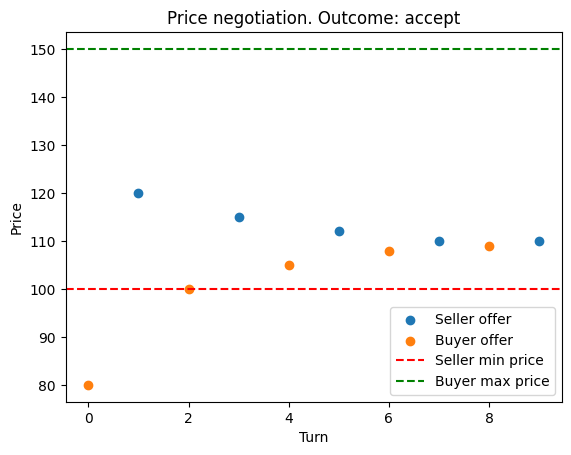

In [80]:
chat.plot()

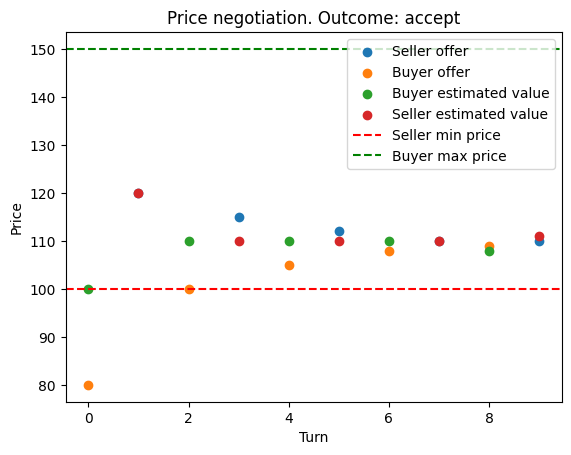

In [81]:
chat.plot(show_other_party_estimated_value=True)

In [59]:
chat = run_negotiation(100, 80,start_speaker="seller",max_message_count=30)

Seller: stragegy="There is no latest offer yet, and my minimum acceptable price is $100. Since there is no offer from the buyer, I will start with a high initial offer to anchor the negotiation in my favor. I will offer $200, which is double my minimum acceptable price, to leave room for negotiation and to test the buyer's maximum acceptable price. I estimate the buyer's maximum acceptable price to be around $150, but I will aim to negotiate above that if possible." estimated_value_of_other_party=150.0 message_to_other_party="I am offering the item for $200. Let's see if we can reach a mutually beneficial agreement." response_type='offer' offer=200.0
Buyer: stragegy="The seller's latest offer is $200, which is significantly higher than my maximum acceptable price of $80. I will make a counteroffer significantly lower than my maximum acceptable price to start the negotiation process. I estimate the seller's minimum acceptable price to be around $150, so I will offer $50 to anchor the ne

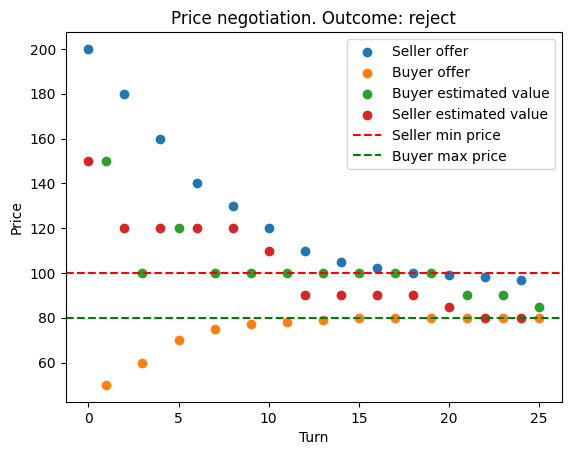

In [60]:
chat.plot(show_other_party_estimated_value=True)

In [61]:
repeats = 3
buyer_values = [700, 800, 900,1000,1100,1200,1300,1400,1500]
seller_value = 1000
chats = [[run_negotiation(seller_value, buyer_value) for _ in range(repeats)] for buyer_value in buyer_values]

Seller: stragegy="There is no latest offer yet, and my minimum acceptable price is $1000. Since there is no offer from the buyer, I will start with a high initial offer to anchor the negotiation in my favor. I will offer $2000, which is double my minimum acceptable price, to leave room for negotiation and to test the buyer's maximum acceptable price. This will also give me a strategic advantage by setting a high starting point." estimated_value_of_other_party=1500.0 message_to_other_party="Let's start the negotiation. I'm offering the item for $2000." response_type='offer' offer=2000.0
Buyer: stragegy="The seller's latest offer is $2000, which is significantly higher than my maximum acceptable price of $700. I will make a counteroffer that is much lower to anchor the negotiation closer to my target price. I estimate the seller's minimum acceptable price to be around $1000, but I will start with a low offer to test their flexibility and willingness to negotiate. I will offer $300 to see

In [62]:
import pickle
with open("data/negotiation_chats_impatient_prompt_seller_starts.pkl","wb") as f:
    pickle.dump(chats,f)

In [94]:
import pickle
with open("data/negotiation_chats_impatient_prompt_seller_starts.pkl","rb") as f:
    chats = pickle.load(f)

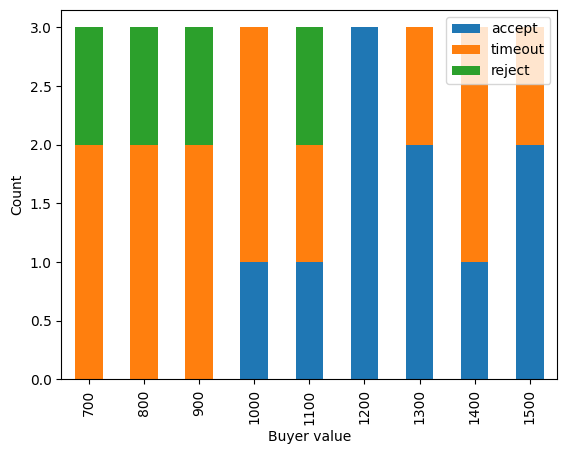

/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


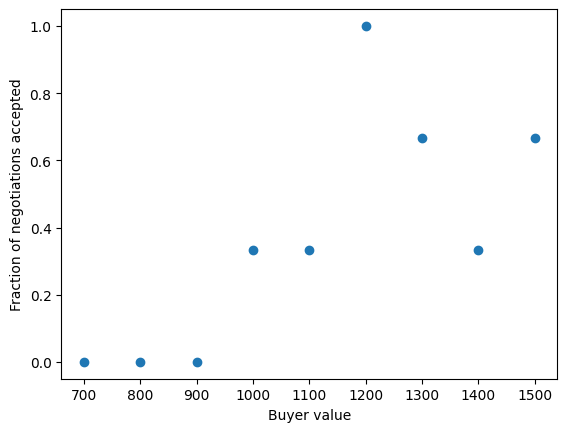

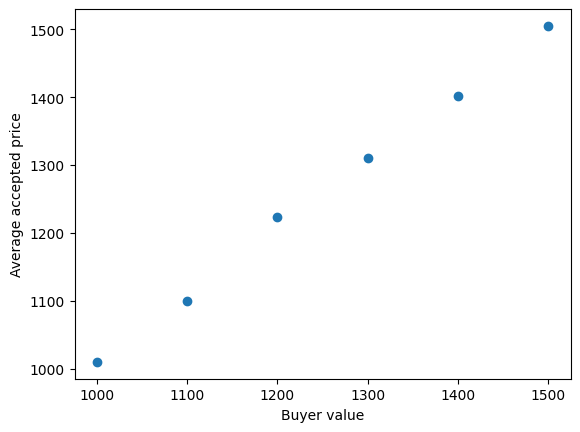

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def get_outcome(n: Negotiation)-> Optional[float]:
    if n.chat[-1][1].response_type == "accept":
        return n.chat[-2][1].offer
    return None

def get_outcome_type(n: Negotiation)-> str:
    return n.chat[-1][1].response_type

# get distribution of outcome types

accept_counts = [sum([get_outcome_type(n) == "accept" for n in chat]) for chat in chats]
offer_counts = [sum([get_outcome_type(n) == "offer" for n in chat]) for chat in chats]
reject_counts = [sum([get_outcome_type(n) == "reject" for n in chat]) for chat in chats]

# create a stacked bar plot
import pandas as pd
df = pd.DataFrame({"accept":accept_counts,"timeout":offer_counts,"reject":reject_counts},index=buyer_values)
df.plot(kind="bar",stacked=True)
plt.xlabel("Buyer value")
plt.ylabel("Count")
plt.show()


percentages_accepted = [sum([get_outcome(n) is not None for n in chat])/len(chat) for chat in chats]
average_accepted = [np.mean([get_outcome(n) for n in chat if get_outcome(n) is not None]) for chat in chats]
plt.scatter(buyer_values, percentages_accepted)
plt.xlabel("Buyer value")
plt.ylabel("Fraction of negotiations accepted")
plt.show()
plt.scatter(buyer_values, average_accepted)
plt.xlabel("Buyer value")
plt.ylabel("Average accepted price")
plt.show()

/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


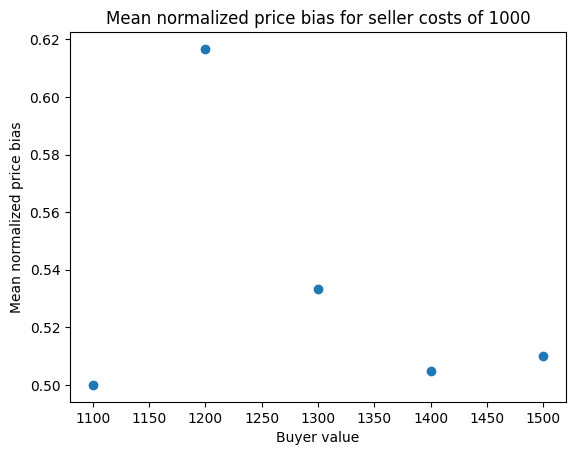

In [67]:
# compute normalized price biases
def get_normalized_price_bias(n: Negotiation)-> Optional[float]:
    if n.chat[-1][1].response_type == "accept":
        price = n.chat[-2][1].offer
        if n.max_price == n.min_price:
            return None
        return (price - n.min_price) / (n.max_price - n.min_price) - 0.5
    return None

npb_means = [np.mean([get_normalized_price_bias(n) for n in chat if get_normalized_price_bias(n) is not None]) for chat in chats]

plt.scatter(buyer_values, npb_means)
plt.xlabel("Buyer value")
plt.ylabel("Mean normalized price bias")
plt.title(f"Mean normalized price bias for seller costs of {seller_value}")
plt.show()

In [68]:
repeats = 3
buyer_values = [700, 800, 900,1000,1100,1200,1300,1400,1500]
seller_value = 1000
chats = [[run_negotiation(seller_value, buyer_value,start_speaker="buyer") for _ in range(repeats)] for buyer_value in buyer_values]

Buyer: stragegy="There is no latest offer yet, and my maximum acceptable price is $700. Since there is no offer from the seller, I will start with a low offer to anchor the negotiation in my favor. I will offer $400, which is significantly below my maximum acceptable price, to leave room for negotiation. I estimate the seller's minimum acceptable price might be around $600, but I will start low to test their flexibility." estimated_value_of_other_party=600.0 message_to_other_party='I would like to offer $400 for the item.' response_type='offer' offer=400.0
Seller: stragegy="The latest offer from the buyer is $400, which is significantly below my minimum acceptable price of $1000. I will reject this offer as it is not even close to my minimum acceptable price. My goal is to maximize the final price, and I estimate the buyer's maximum acceptable price to be around $1200. I will make a counteroffer to start the negotiation closer to my target price." estimated_value_of_other_party=1200.0 

In [69]:
import pickle
with open("data/negotiation_chats_impatient_prompt_buyer_starts.pkl","wb") as f:
    pickle.dump(chats,f)

In [97]:
import pickle
with open("data/negotiation_chats_impatient_prompt_buyer_starts.pkl","rb") as f:
    chats = pickle.load(f)

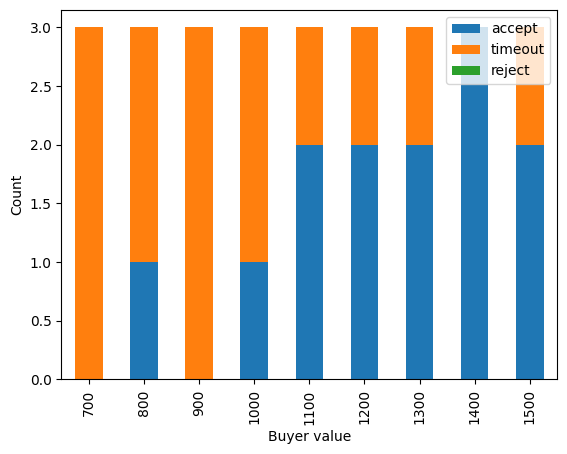

/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ole/Documents/software/scientific/bargaining_llms/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


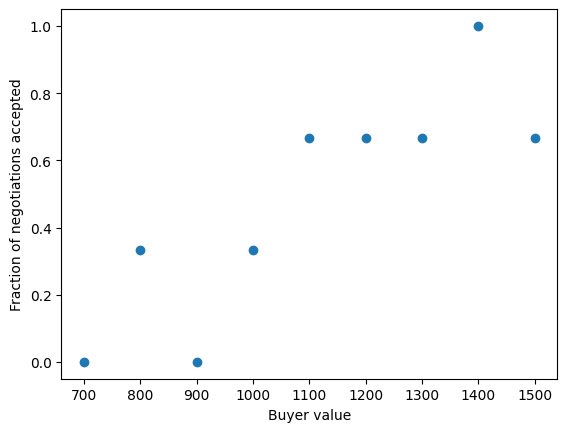

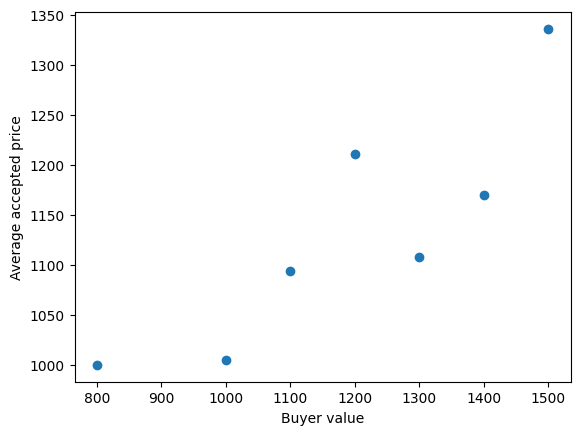

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def get_outcome(n: Negotiation)-> Optional[float]:
    if n.chat[-1][1].response_type == "accept":
        return n.chat[-2][1].offer
    return None

def get_outcome_type(n: Negotiation)-> str:
    return n.chat[-1][1].response_type

# get distribution of outcome types

accept_counts = [sum([get_outcome_type(n) == "accept" for n in chat]) for chat in chats]
offer_counts = [sum([get_outcome_type(n) == "offer" for n in chat]) for chat in chats]
reject_counts = [sum([get_outcome_type(n) == "reject" for n in chat]) for chat in chats]

# create a stacked bar plot
import pandas as pd
df = pd.DataFrame({"accept":accept_counts,"timeout":offer_counts,"reject":reject_counts},index=buyer_values)
df.plot(kind="bar",stacked=True)
plt.xlabel("Buyer value")
plt.ylabel("Count")
plt.show()


percentages_accepted = [sum([get_outcome(n) is not None for n in chat])/len(chat) for chat in chats]
average_accepted = [np.mean([get_outcome(n) for n in chat if get_outcome(n) is not None]) for chat in chats]
plt.scatter(buyer_values, percentages_accepted)
plt.xlabel("Buyer value")
plt.ylabel("Fraction of negotiations accepted")
plt.show()
plt.scatter(buyer_values, average_accepted)
plt.xlabel("Buyer value")
plt.ylabel("Average accepted price")
plt.show()

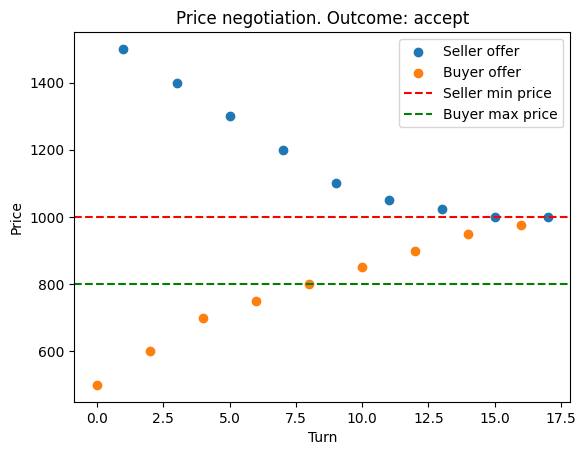

[('buyer',
  BargainingMessage(stragegy="There is no latest offer yet, and my maximum acceptable price is $800. Since there is no offer from the seller, I will start with a low offer to anchor the negotiation in my favor. I will offer $500, which is significantly below my maximum acceptable price, to leave room for negotiation. I estimate the seller's minimum acceptable price might be around $700, but I will aim to negotiate below that if possible.", estimated_value_of_other_party=700.0, message_to_other_party='I would like to offer $500 for the item.', response_type='offer', offer=500.0)),
 ('seller',
  BargainingMessage(stragegy="The latest offer from the buyer is $500, which is significantly below my minimum acceptable price of $1000. I will reject this offer and make a counteroffer. My goal is to maximize the final price, and I believe the buyer's maximum acceptable price is likely higher than $1000. I will start with a counteroffer of $1500 to leave room for negotiation and to tes

In [78]:
# investigate deal being made at 800 min price
relevant_chats = [chat for chat in chats[1] if get_outcome(chat) is not None]
chat = relevant_chats[0]
assert chat.max_price == 800
chat.plot()
chat.chat

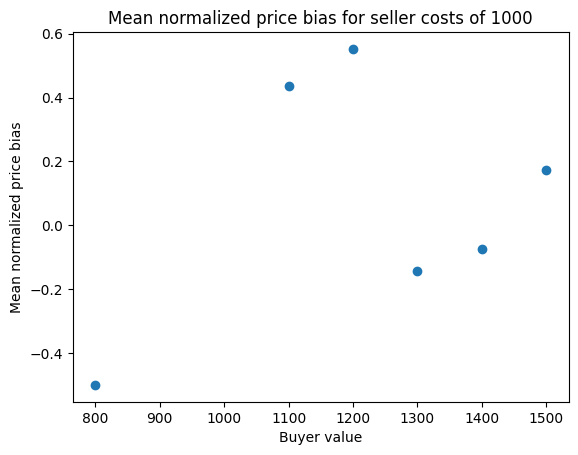

In [71]:
# compute normalized price biases
def get_normalized_price_bias(n: Negotiation)-> Optional[float]:
    if n.chat[-1][1].response_type == "accept":
        price = n.chat[-2][1].offer
        if n.max_price == n.min_price:
            return None
        return (price - n.min_price) / (n.max_price - n.min_price) - 0.5
    return None

npb_means = [np.mean([get_normalized_price_bias(n) for n in chat if get_normalized_price_bias(n) is not None]) for chat in chats]

plt.scatter(buyer_values, npb_means)
plt.xlabel("Buyer value")
plt.ylabel("Mean normalized price bias")
plt.title(f"Mean normalized price bias for seller costs of {seller_value}")
plt.show()